In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datast/Employee_Performance_Retention.csv


In [3]:
import os, time, warnings, pickle
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.inspection import permutation_importance
from joblib import dump

# Try shap for explainability (optional)
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# Create results folder
os.makedirs("results", exist_ok=True)
print("SHAP available:", SHAP_AVAILABLE)

SHAP available: True


In [4]:
DATA_PATH = "/kaggle/input/datast/Employee_Performance_Retention.csv"
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH}. Upload the CSV to that path in Kaggle.")

df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", DATA_PATH)
print("Shape:", df.shape)
display(df.head())

# Basic info
print("\n--- Data info ---")
print(df.info())
print("\n--- Summary statistics ---")
display(df.describe(include='all').T)

# Save initial snapshot
df.head().to_csv("results/original_head_snapshot.csv", index=False)


Loaded dataset: /kaggle/input/datast/Employee_Performance_Retention.csv
Shape: (9000, 10)


,Employee_ID,Age,Department,Years_of_Experience,Monthly_Working_Hours,Training_Hours_per_Year,Performance_Rating,Job_Satisfaction_Level,Promotion_in_Last_2_Years,Attrition
0,E1000,59,Sales,27,135,30,3,Medium,Yes,No
1,E1001,49,Tech,13,132,36,5,Medium,Yes,Yes
2,E1002,35,Operations,16,197,11,5,Low,No,No
3,E1003,28,HR,23,204,36,3,High,No,No
4,E1004,41,Operations,33,192,36,2,Medium,No,No



--- Data info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Employee_ID                9000 non-null   object
 1   Age                        9000 non-null   int64 
 2   Department                 9000 non-null   object
 3   Years_of_Experience        9000 non-null   int64 
 4   Monthly_Working_Hours      9000 non-null   int64 
 5   Training_Hours_per_Year    9000 non-null   int64 
 6   Performance_Rating         9000 non-null   int64 
 7   Job_Satisfaction_Level     9000 non-null   object
 8   Promotion_in_Last_2_Years  9000 non-null   object
 9   Attrition                  9000 non-null   object
dtypes: int64(5), object(5)
memory usage: 703.3+ KB
None

--- Summary statistics ---


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Employee_ID,9000,9000,E9999,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,9000.0,NaN,NaN,NaN,40.113667,11.178092,21.0,31.0,40.0,50.0,59.0
Department,9000,5,Operations,1843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years_of_Experience,9000.0,NaN,NaN,NaN,16.980111,10.030554,0.0,8.0,17.0,26.0,34.0
Monthly_Working_Hours,9000.0,NaN,NaN,NaN,184.901,37.557676,120.0,152.0,185.0,217.0,249.0
Training_Hours_per_Year,9000.0,NaN,NaN,NaN,24.441889,14.427219,0.0,12.0,25.0,37.0,49.0
Performance_Rating,9000.0,NaN,NaN,NaN,3.096444,1.093998,1.0,2.0,3.0,4.0,5.0
Job_Satisfaction_Level,9000,3,Medium,4501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Promotion_in_Last_2_Years,9000,2,No,8074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attrition,9000,2,No,7247,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing values per column:
Employee_ID                  0
Age                          0
Department                   0
Years_of_Experience          0
Monthly_Working_Hours        0
Training_Hours_per_Year      0
Performance_Rating           0
Job_Satisfaction_Level       0
Promotion_in_Last_2_Years    0
Attrition                    0
dtype: int64


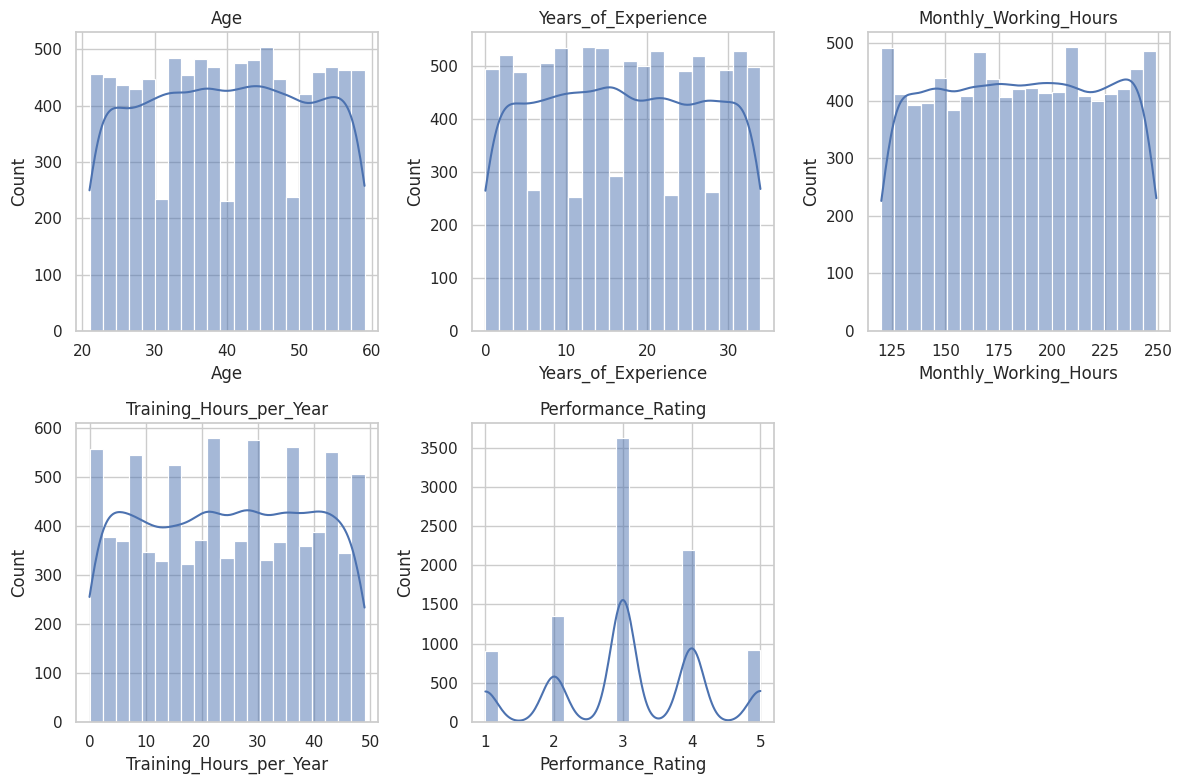

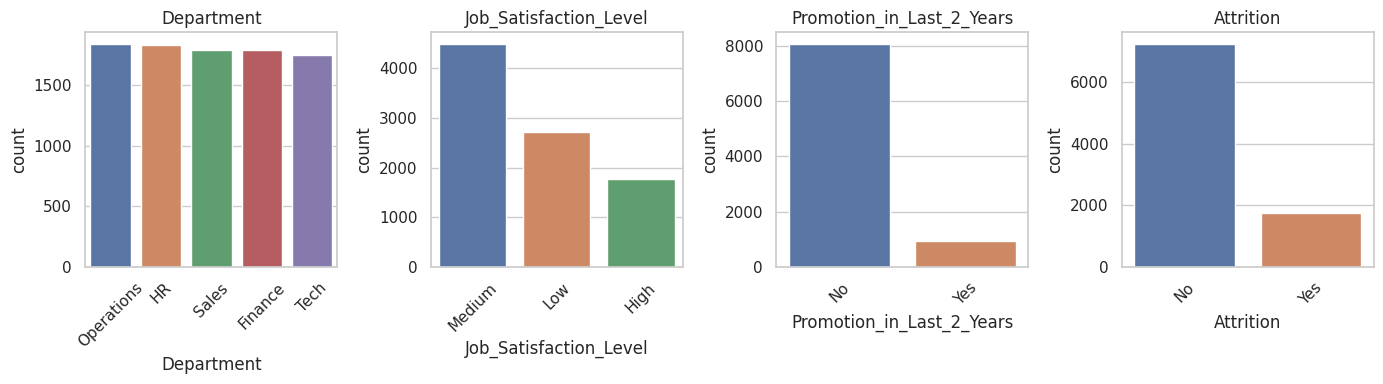

Overall attrition rate: 19.48%


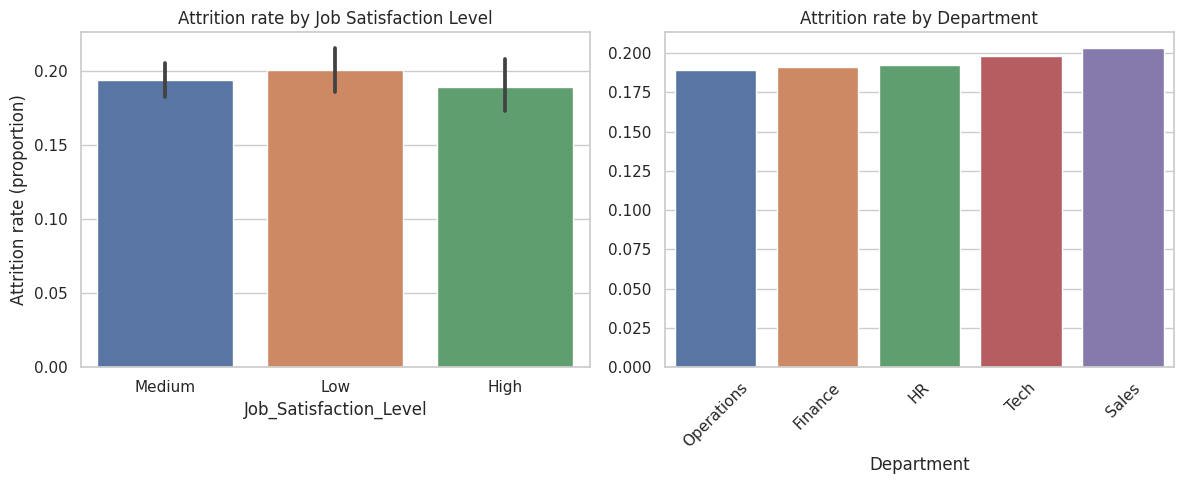

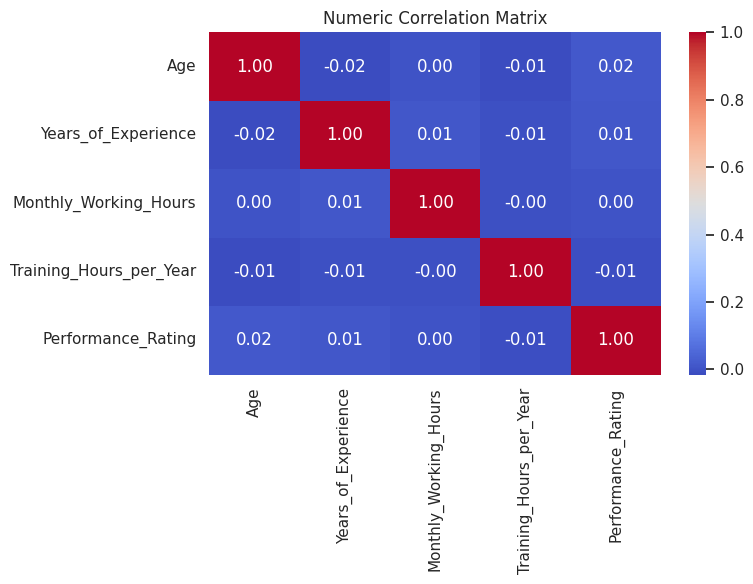


Quick EDA insights (auto):
- If job satisfaction categories show different attrition rates, that's a strong signal.
- Check departments with high attrition rates for operational issues.
- Use correlation heatmap to spot collinearity among numeric features.


In [5]:
print("\nMissing values per column:")
print(df.isnull().sum())

# Numeric distributions
num_cols = ["Age", "Years_of_Experience", "Monthly_Working_Hours", "Training_Hours_per_Year", "Performance_Rating"]
num_cols = [c for c in num_cols if c in df.columns]

plt.figure(figsize=(12,8))
for i, c in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(df[c], kde=True)
    plt.title(c)
plt.tight_layout()
plt.savefig("results/eda_numeric_distributions.png", dpi=150)
plt.show()

# Categorical distributions
cat_cols = [c for c in ["Department","Job_Satisfaction_Level","Promotion_in_Last_2_Years","Attrition"] if c in df.columns]
plt.figure(figsize=(14,4))
for i, c in enumerate(cat_cols, 1):
    plt.subplot(1, len(cat_cols), i)
    order = df[c].value_counts().index
    sns.countplot(x=c, data=df, order=order)
    plt.title(c)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("results/eda_categorical_counts.png", dpi=150)
plt.show()

# Attrition proportion
if "Attrition" in df.columns:
    attr_rate = (df["Attrition"]=="Yes").mean()
    print(f"Overall attrition rate: {attr_rate:.2%}")

# Attrition vs Job Satisfaction & Department
if set(["Attrition","Job_Satisfaction_Level"]).issubset(df.columns):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.barplot(x="Job_Satisfaction_Level", y=(df["Attrition"]=="Yes").astype(int), data=df)
    plt.title("Attrition rate by Job Satisfaction Level")
    plt.ylabel("Attrition rate (proportion)")

if "Department" in df.columns:
    plt.subplot(1,2,2)
    dept_rates = df.groupby("Department").apply(lambda d: (d["Attrition"]=="Yes").mean()).sort_values()
    sns.barplot(x=dept_rates.index, y=dept_rates.values)
    plt.xticks(rotation=45); plt.title("Attrition rate by Department")
plt.tight_layout()
plt.savefig("results/eda_attrition_by_group.png", dpi=150)
plt.show()

# Correlation heatmap (numerical)
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric Correlation Matrix")
plt.tight_layout()
plt.savefig("results/eda_correlation_heatmap.png", dpi=150)
plt.show()

# Insights note (printed)
print("\nQuick EDA insights (auto):")
print("- If job satisfaction categories show different attrition rates, that's a strong signal.")
print("- Check departments with high attrition rates for operational issues.")
print("- Use correlation heatmap to spot collinearity among numeric features.")


In [7]:
# Make a working copy of the dataframe for processing
df_proc = df.copy()

# Drop Employee_ID
if "Employee_ID" in df_proc.columns:
    df_proc.drop("Employee_ID", axis=1, inplace=True)

# Label-encode Job_Satisfaction_Level, Promotion_in_Last_2_Years, Attrition (keep mapping for explainability)
label_encoders = {}
for col in ["Job_Satisfaction_Level", "Promotion_in_Last_2_Years", "Attrition"]:
    if col in df_proc.columns:
        le = LabelEncoder()
        df_proc[col + "_enc"] = le.fit_transform(df_proc[col])
        label_encoders[col] = {
            "classes": list(le.classes_),
            "mapping": dict(zip(le.classes_, le.transform(le.classes_)))
        }
        print(f"Encoded {col}: {label_encoders[col]['mapping']}")

# One-hot encode Department
if "Department" in df_proc.columns:
    df_proc = pd.get_dummies(df_proc, columns=["Department"], drop_first=True)
    print("One-hot encoded Department. New columns added:", [c for c in df_proc.columns if c.startswith("Department_")][:10])

# Numeric scaling (scale numeric columns only)
numeric_cols = [c for c in ["Age","Years_of_Experience","Monthly_Working_Hours","Training_Hours_per_Year"] if c in df_proc.columns]
scaler = StandardScaler()
if numeric_cols:
    df_proc[numeric_cols] = scaler.fit_transform(df_proc[numeric_cols])
    print("Scaled numeric columns:", numeric_cols)

# Save processed snapshot & encoders
df_proc.to_csv("results/processed_snapshot.csv", index=False)
with open("results/label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# Final feature matrix
feature_cols = [
    c for c in df_proc.columns
    if c not in [
        "Performance_Rating", "Attrition", "Attrition_enc",
        "Job_Satisfaction_Level", "Promotion_in_Last_2_Years"
    ]
]

# Ensure encoded columns are included
for enc in ["Job_Satisfaction_Level_enc", "Promotion_in_Last_2_Years_enc", "Attrition_enc"]:
    if enc in df_proc.columns and enc not in feature_cols:
        feature_cols.append(enc)

# Features and targets
X = df_proc[feature_cols].copy()
y = df_proc["Attrition_enc"].copy()
X_reg = X.copy()
y_reg = df_proc["Performance_Rating"].copy()

print("\nFinal features (sample):", feature_cols[:12])
print("Feature matrix shape:", X.shape)


Encoded Job_Satisfaction_Level: {'High': 0, 'Low': 1, 'Medium': 2}
Encoded Promotion_in_Last_2_Years: {'No': 0, 'Yes': 1}
Encoded Attrition: {'No': 0, 'Yes': 1}
One-hot encoded Department. New columns added: ['Department_HR', 'Department_Operations', 'Department_Sales', 'Department_Tech']
Scaled numeric columns: ['Age', 'Years_of_Experience', 'Monthly_Working_Hours', 'Training_Hours_per_Year']

Final features (sample): ['Age', 'Years_of_Experience', 'Monthly_Working_Hours', 'Training_Hours_per_Year', 'Job_Satisfaction_Level_enc', 'Promotion_in_Last_2_Years_enc', 'Department_HR', 'Department_Operations', 'Department_Sales', 'Department_Tech', 'Attrition_enc']
Feature matrix shape: (9000, 11)


In [8]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.20, random_state=42)

print("Classification split:", Xc_train.shape, Xc_test.shape)
print("Regression split:", Xr_train.shape, Xr_test.shape)


Classification split: (7200, 11) (1800, 11)
Regression split: (7200, 11) (1800, 11)


In [9]:
def eval_classification(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n{name} metrics — Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def save_model(obj, name):
    path = f"results/{name}.joblib"
    dump(obj, path)
    print(f"Saved model to {path}")

# Container to collect model results
model_results = []


RandomForest (baseline) metrics — Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       351

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



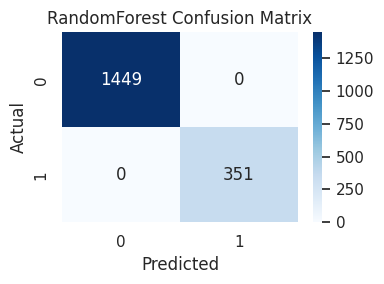

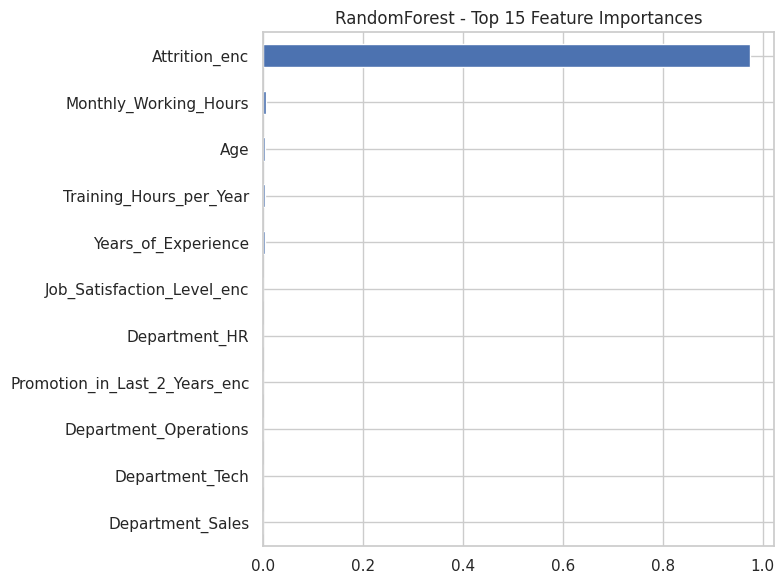

Saved model to results/random_forest_classifier.joblib


In [10]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
t0 = time.time()
rf.fit(Xc_train, yc_train)
t_rf = time.time() - t0
y_rf = rf.predict(Xc_test)
rf_metrics = eval_classification("RandomForest (baseline)", yc_test, y_rf)
plot_conf_matrix(yc_test, y_rf, "RandomForest Confusion Matrix")
# Feature importance
fi_rf = pd.Series(rf.feature_importances_, index=Xc_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
fi_rf.head(15).sort_values().plot(kind="barh")
plt.title("RandomForest - Top 15 Feature Importances")
plt.tight_layout(); plt.savefig("results/rf_top15_importance.png", dpi=150); plt.show()
fi_rf.head(30).to_csv("results/rf_feature_importances.csv")

# Save RF model
save_model(rf, "random_forest_classifier")
model_results.append(("RandomForest", rf_metrics, t_rf))



--- SVM kernel: linear ---

SVM-linear metrics — Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       351

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



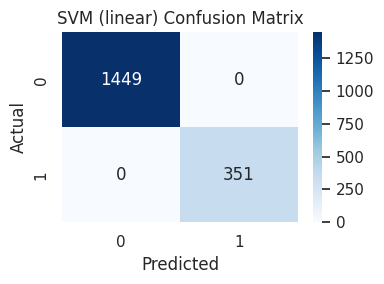

Saved model to results/svm_linear.joblib

--- SVM kernel: poly ---

SVM-poly metrics — Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       351

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



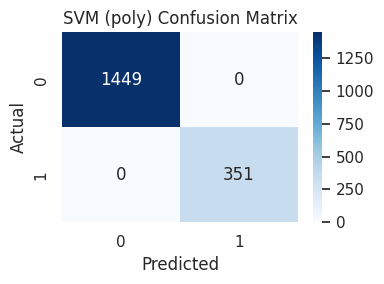

Saved model to results/svm_poly.joblib

--- SVM kernel: rbf ---

SVM-rbf metrics — Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       351

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



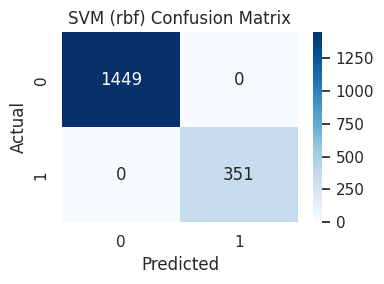

Saved model to results/svm_rbf.joblib


In [11]:
svm_kernels = ["linear", "poly", "rbf"]
svm_summary = {}
for k in svm_kernels:
    print("\n--- SVM kernel:", k, "---")
    svm = SVC(kernel=k, probability=True, class_weight="balanced", random_state=42)
    t0 = time.time(); svm.fit(Xc_train, yc_train); t_svm = time.time() - t0
    y_s = svm.predict(Xc_test)
    metrics = eval_classification(f"SVM-{k}", yc_test, y_s)
    plot_conf_matrix(yc_test, y_s, f"SVM ({k}) Confusion Matrix")
    save_model(svm, f"svm_{k}")
    svm_summary[k] = {"metrics": metrics, "train_time": t_svm}
    model_results.append((f"SVM_{k}", metrics, t_svm))


XGBoost best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

XGBoost (tuned) metrics — Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1449
           1       1.00      1.00      1.00       351

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



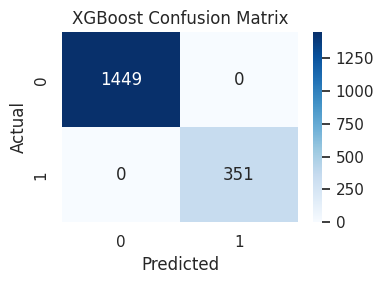

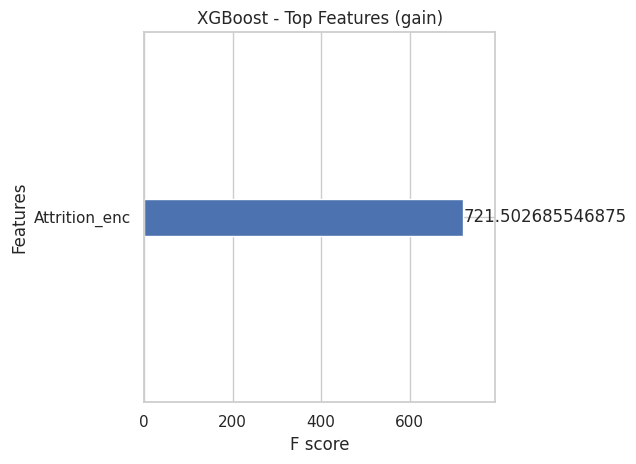

Saved model to results/xgboost_tuned.joblib


In [12]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
param_grid = {"n_estimators": [100,200], "max_depth": [3,5], "learning_rate": [0.05, 0.1]}
grid = GridSearchCV(xgb_clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=0)

t0 = time.time()
grid.fit(Xc_train, yc_train)
t_xgb = time.time() - t0

best_xgb = grid.best_estimator_
print("XGBoost best params:", grid.best_params_)

y_xgb = best_xgb.predict(Xc_test)
xgb_metrics = eval_classification("XGBoost (tuned)", yc_test, y_xgb)
plot_conf_matrix(yc_test, y_xgb, "XGBoost Confusion Matrix")
# save feature importance and model
xgb.plot_importance(best_xgb, max_num_features=15, importance_type="gain")
plt.title("XGBoost - Top Features (gain)"); plt.tight_layout(); plt.savefig("results/xgb_feature_importance.png", dpi=150); plt.show()
save_model(best_xgb, "xgboost_tuned")
pd.DataFrame(grid.cv_results_).to_csv("results/xgb_grid_results.csv", index=False)
model_results.append(("XGBoost", xgb_metrics, t_xgb))


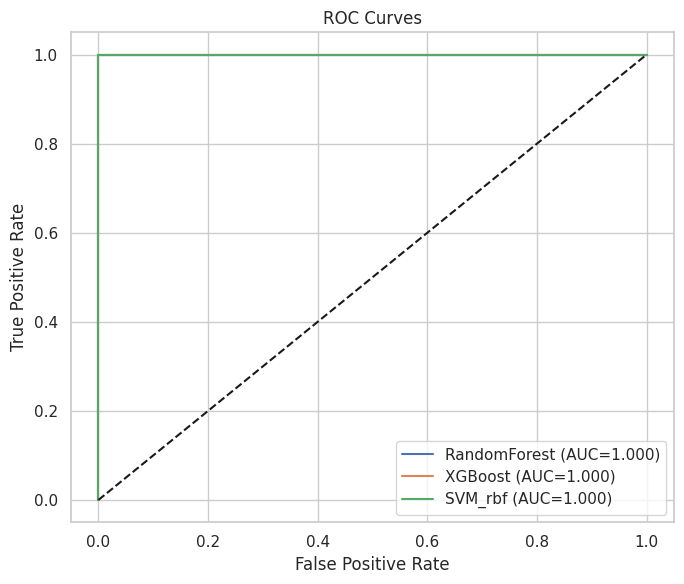

In [13]:
models_for_roc = {"RandomForest": rf, "XGBoost": best_xgb}
# ensure SVM rbf exists and has probability=True
svm_rbf = SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)
svm_rbf.fit(Xc_train, yc_train)
models_for_roc["SVM_rbf"] = svm_rbf

plt.figure(figsize=(7,6))
for name, model in models_for_roc.items():
    prob = model.predict_proba(Xc_test)[:,1]
    fpr, tpr, _ = roc_curve(yc_test, prob)
    auc = roc_auc_score(yc_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curves")
plt.legend(); plt.tight_layout(); plt.savefig("results/roc_curves.png", dpi=150); plt.show()


Computing SHAP values (may take time)...


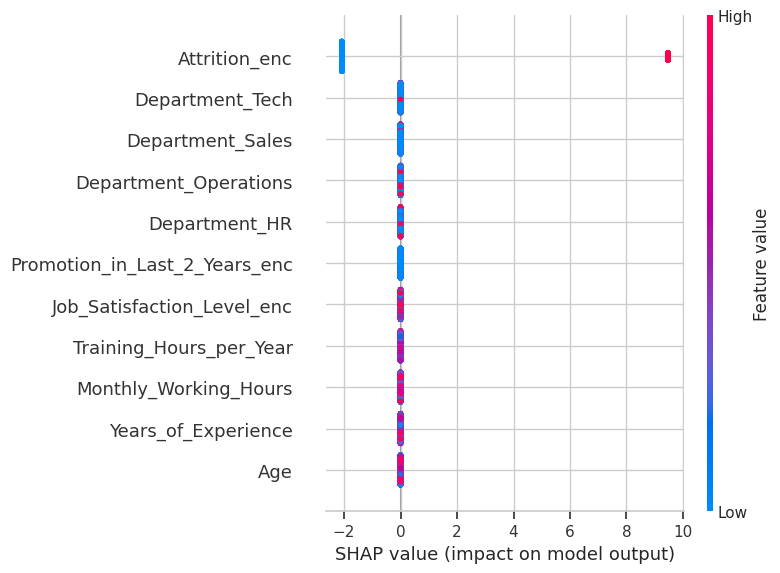

<Figure size 640x480 with 0 Axes>

In [15]:
# Ensure numeric input for SHAP
Xc_train_np = Xc_train.values.astype(float)
Xc_test_np = Xc_test.values.astype(float)

if SHAP_AVAILABLE:
    print("Computing SHAP values (may take time)...")
    explainer = shap.Explainer(best_model_for_explain, Xc_train_np)
    shap_values = explainer(Xc_test_np)
    shap.summary_plot(shap_values, Xc_test_np, feature_names=Xc_test.columns)
    plt.savefig("results/shap_summary.png", dpi=150)
else:
    print("Using permutation importance (fallback)")
    perm = permutation_importance(
        best_model_for_explain, Xc_test, yc_test,
        n_repeats=25, random_state=42, n_jobs=-1
    )
    idx = perm.importances_mean.argsort()
    plt.figure(figsize=(8,6))
    plt.barh(Xc_test.columns[idx][-15:], perm.importances_mean[idx][-15:])
    plt.title("Permutation importance (top 15)")
    plt.tight_layout()
    plt.savefig("results/permutation_importance.png", dpi=150)
    plt.show()

    pd.Series(perm.importances_mean, index=Xc_test.columns)\
        .sort_values(ascending=False)\
        .to_csv("results/permutation_importance.csv")


RF Regressor — train_time=1.72s | MSE=1.3314 | MAE=0.9107 | R2=-0.0492


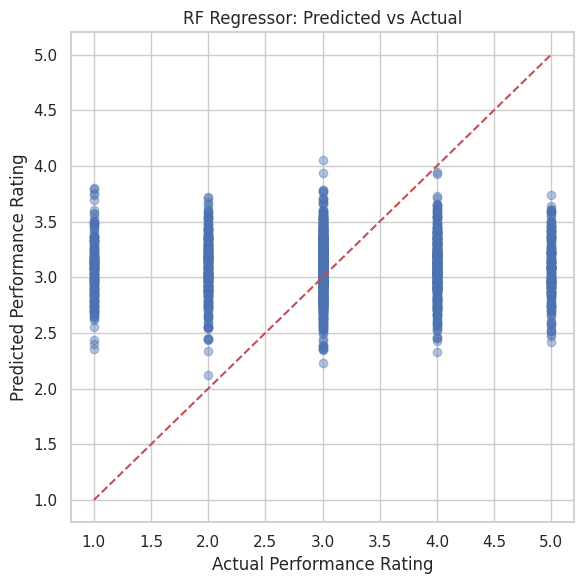

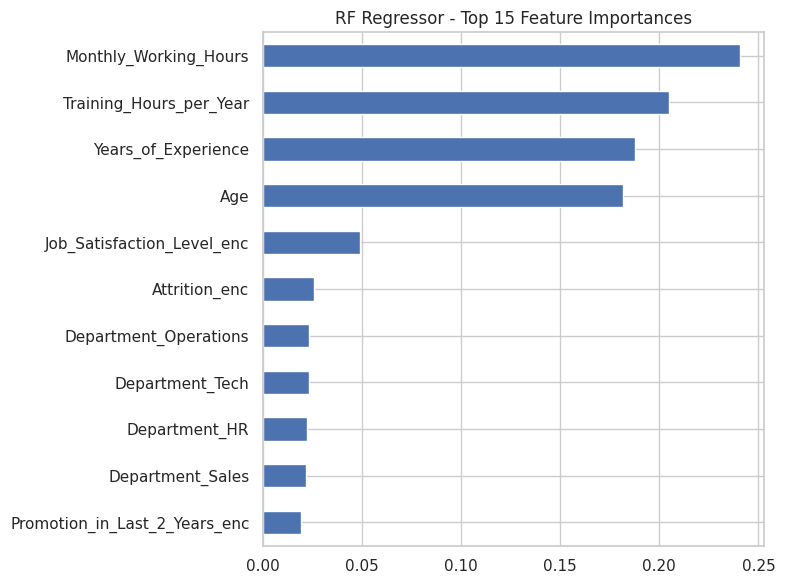

Saved model to results/rf_regressor_performance_rating.joblib


In [16]:
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
t0 = time.time(); rf_reg.fit(Xr_train, yr_train); t_reg = time.time() - t0
y_reg_pred = rf_reg.predict(Xr_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(yr_test, y_reg_pred)
mae = mean_absolute_error(yr_test, y_reg_pred)
r2 = r2_score(yr_test, y_reg_pred)
print(f"RF Regressor — train_time={t_reg:.2f}s | MSE={mse:.4f} | MAE={mae:.4f} | R2={r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(yr_test, y_reg_pred, alpha=0.4)
plt.plot([yr_test.min(), yr_test.max()],[yr_test.min(), yr_test.max()],"r--")
plt.xlabel("Actual Performance Rating"); plt.ylabel("Predicted Performance Rating")
plt.title("RF Regressor: Predicted vs Actual")
plt.tight_layout(); plt.savefig("results/regressor_pred_vs_actual.png", dpi=150); plt.show()

# Regression feature importances
fi_reg = pd.Series(rf_reg.feature_importances_, index=Xr_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6)); fi_reg.head(15).sort_values().plot(kind="barh")
plt.title("RF Regressor - Top 15 Feature Importances"); plt.tight_layout(); plt.savefig("results/rf_reg_feature_importance.png", dpi=150); plt.show()
fi_reg.head(50).to_csv("results/rf_reg_feature_importances.csv")

# Save regressor
save_model(rf_reg, "rf_regressor_performance_rating")


In [17]:
rows = []
# add RF baseline
rows.append({"model":"RandomForest", **rf_metrics, "train_time_s": t_rf})
# add XGBoost
rows.append({"model":"XGBoost", **xgb_metrics, "train_time_s": t_xgb})
# add SVM entries
for k, v in svm_summary.items():
    rows.append({"model": f"SVM_{k}", **v["metrics"], "train_time_s": v["train_time"]})

summary_df = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
display(summary_df)
summary_df.to_csv("results/model_comparison_summary.csv", index=False)

# Save best model as "final_model.joblib"
# Choose best by F1 in summary_df
best_row = summary_df.loc[0, "model"]
print("Top model by F1:", best_row)
if "XGBoost" in best_row:
    save_model(best_xgb, "final_model_xgboost")
elif "RandomForest" in best_row:
    save_model(rf, "final_model_randomforest")
else:
    # pick appropriate SVM (we saved earlier)
    # note: SVM models saved earlier as joblib (svm_linear, svm_poly, svm_rbf)
    # We'll just indicate where to find them
    print("SVM selected as top model — saved as results/svm_<kernel>.joblib")


,model,accuracy,precision,recall,f1,train_time_s
0,RandomForest,1.0,1.0,1.0,1.0,0.560533
1,XGBoost,1.0,1.0,1.0,1.0,2.658590
2,SVM_linear,1.0,1.0,1.0,1.0,0.033983
3,SVM_poly,1.0,1.0,1.0,1.0,0.910170
4,SVM_rbf,1.0,1.0,1.0,1.0,0.730188


Top model by F1: RandomForest
Saved model to results/final_model_randomforest.joblib
